# Sentiment Analyse von Kryptowährungs-Tweets
---

### Inhaltsverzeichnis
* [1. Data Mining](#1.-Data-Mining)
  - [1.1 Datenqualität von TweetArchivist](#1.1-Daten-von-TweetArchivist)
  - [1.2 Sprache Filtern](#1.2-Sprache-Filtern)
  - [1.3 Noise Reduction](#1.3-Noise-Reduction)
  - [1.4 Tweets per API Laden](#1.4-Tweets-per-API-Laden)
  - [1.5 Krypto- Daten](#1.5-Krypto--Daten)
* [2. Regelbasierte Sentiment Analysis](#2.-Regelbasierte-Sentiment-Analysis)
  - [2.1 Vader](#2.1-Vader)
  - [2.1 AFINN](#2.2-AFINN)
* [3. Machine Learning Sentiment Analysis](#3.-Machine-Learning-Sentiment-Analysis)
  - [3.1 Datenvorbereitung](#3.1-Datenvorbereitung)
    - [3.1.1 Preprocessing](#3.1.1-Preprocessing)
    - [3.1.2 Labeling](#3.1.2-Labeling)
    - [3.1.3 Aufteilung in Trainings- und Testdaten](#3.1.3-Aufteilung-in-Trainings--und-Testdaten)
  - [3.2 Word Embeddings Modell](#3.2-Word-Embeddings-Modell)
    - [3.2.1 Word2Vec Modell](#3.2.1-Word2Vec-Modell)
  - [3.3 RNN Modell](#3.3-RNN-Modell)
    - [3.3.1 Embeddings Layer](#3.3.1-Embeddings-Layer)
    - [3.3.2 Neuronales Netz](#3.3.2-Neuronales-Netz)
    - [3.3.3 Modell trainieren](#3.3.3-Modell-trainieren)
    - [3.3.4 Modell auf Testdaten anwenden](#3.3.4-Modell-auf-Testdaten-anwenden)
    - [3.3.5 Modell auswerten](#3.3.4-Modell-auswerten)
* [4. Sentiment Klassifizierung der Kryptowährungs-Tweets](#4.-Sentiment-Klassifizierung-der-Tweets)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [3]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

In [4]:
pd.options.display.max_rows = 4000
pd.options.display.max_colwidth = 1000

In [4]:
%%html
<style>
.p-Widget.jp-Cell.jp-Notebook-cell {
    width: 1024px;
    margin: auto;
}
</style>

---

# 1. Data Mining

Tweets wurden über einen bestimmten Zeitraum mithilfe des [TweetArchivist](https://www.tweetarchivist.com/) Dienstes gesammelt. <br>
Dabei kann ein Query hinterlegt werden, welches auf täglicher Basis ausgeführt wird und alle Tweets liefert, welche dem Query entsprechen. Die Daten können dann als *.xlsx Datei heruntergeladen werden.

In [5]:
df = pd.read_excel("./data/reddcoin.xlsx")
df.head(2)

ID      User Name Universal Time Stamp  \
0  1057491321504612353   andre_wiebes  2018-10-31T04:35:52   
1  1057489020467458055  kroegtijger74  2018-10-31T04:26:44   

      Local Time Stamp  \
0  2018-10-31T04:35:52   
1  2018-10-31T04:26:44   

                                                                                                                  Text  \
0                                        RT @RedcoinNL: Whats happend? #RDD #Reddcoin #Bitcoin https://t.co/HmOwqvcjXk   
1  RT @reddcoinnews: Question on https://t.co/w093wCpr9j and staking via /r/reddCoin https://t.co/I0aptvCDA5 #reddcoin   

  Language  \
0       en   
1       en   

                                                                                 Profile Image  \
0                  http://pbs.twimg.com/profile_images/1046105182600400898/9SRv-ahm_normal.jpg   
1  http://pbs.twimg.com/profile_images/3680610664/423800ed216b83e36f49ac87d04191cc_normal.jpeg   

                                                                                 Source  \
0  <a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>   
1    <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   

        Location  Time Zone  Geo              Hashtags  \
0  Heerhugowaard        NaN  NaN  RDD Reddcoin Bitcoin   
1           beek        NaN  NaN              reddcoin   

                                              Urls User Mentions  \
0                                              NaN     RedcoinNL   
1  http://www.reddheads.com https://ift.tt/2DcIvso  reddcoinnews   

                                            Media  Follower Count  \
0  http://pbs.twimg.com/media/DqzAjfzX4AAnhW8.jpg              94   
1                                             NaN              90   

              Name  
0     Andre wiebes  
1  Marco Keurntjes

## 1.1 Daten von TweetArchivist
* Leider sind die Texte der Tweets auf eine bestimmte **Zeichnelänge begrenzt**. <br>Dies beduetet, dass die Texte nicht repräsentativ sind, wie oben zu sehen ist. Allerdings wird uns die Möglichkeit geboten, einen **kompletten** Tweet direkt über die ID zu laden. Allerdings macht es Sinn die "Noise Reduction" bereits auf diesem Datensatz zu machen. Es müssen dann weniger Tweets nachgeladen werden (API Rate Limit!).
* Es sind Tweets in verschiedenen Sprachen vorhanden, wie man der Spalte *Language" entnehmen kann.

In [6]:
df['Text'][7]

'RT @Crypto_Eagle: #Altcoin #altcoin #Bitcoin #bitcoin #BTC $BTC #free #Cryptocurrency #Crypto #cryptocurrency #Reddcoin #DigitalCurrency #G…'

## 1.2 Sprache Filtern
Für die Arbeit sollen **nur englische Tweets** beachtet werden.

In [7]:
from data_mining.data_cleaning import filter_language
df = filter_language(df)

Filter dataset for language 'en'
	Filtered out 1207 rows
	Actual size: 13872


## 1.3 Noise Reduction
Tweets sind sehr "noisy", d.h. dass es viele Tweets gibt welche computer generiert sind (von Bot's). "Bot Detection" im Umfelt von social Media ist ein sehr spannendes Thema, worüber es auch ausreichlich Fachliteratur gibt. Wir konzentrieren uns hier auf einen einfachen Ansatz, welcher im Paper *Algorithmic Trading of Cryptocurrency Based on Twitter Sentiment Analysis* beschreiben wird. Dieser besteht aus zwei Schritten:
1. Links & nicht Alphanummerische Zeichen entfernen
2. Duplikate entfernen

Dies wird bewusst auf den Tweets angewendet, welche abgeschnitten sein könnten. Dies hilft uns dabei, in den nächsten Schritten nicht Tweets per API zu laden, welche nicht relevant sind.

In [8]:
from data_mining.data_cleaning import noise_reduction
df = noise_reduction(df)

Reduce noise on dataset
	Filtered out 9452 duplicates
	Actual size: 4420


## 1.4 Tweets per API laden
Die grösse des DatenFrame's ist wesentlich kleiner geworden. Wir haben jetzt (hoffentlich) nur noch relevante Tweets in userem DatenFrame.<br>
Allerdings haben wir immer noch die (teilweise) abgeschnittenen Tweets. Um dies zu lösen werden wir per [Twitter API](https://developer.twitter.com/en/docs/tweets/post-and-engage/api-reference/get-statuses-lookup.html) die kompletten Tweets mithilfe der **ID** laden.<br>
Dazu verwenden wir die Python Library [Twarc](https://github.com/DocNow/twarc).<br>

Um **Twarc aufzusetzen** sind folgende Schritte nötig:
1. `pip install twarc`
2. `twarc configure` - Hier müssen nun die Twitter API keys hinterlegt werden. Dazu muss zuvor ein [Developer Account](https://developer.twitter.com) bei Twitter beantragt werden.

Wir werden die [Hydrate](https://github.com/DocNow/twarc#hydrate) Funktion von Twarc verwenden. Diese dient genau dazu, aus Tweet ID's den ganzen Tweet per API zu laden. <br> 
Dazu müssen wir aber erst alle Tweet-ID's in ein seperates *.txt File speichern.

In [9]:
from data_mining.data_enhancing import write_id_file
write_id_file(df, "./data/data_enhancing/reddcoin_ids.txt")

**Nun können wir die Tweets laden:**<br>
`twarc hydrate data/data_enhancing/reddcoin_ids.txt > data/data_enhancing/reddcoin_tweets.jsonl`

In [10]:
df = pd.read_json('./data/data_enhancing/reddcoin_tweets.jsonl', lines=True)
df.head(2)

contributors  coordinates          created_at display_text_range  \
0           NaN          NaN 2018-10-28 16:21:24           [13, 21]   
1           NaN          NaN 2018-10-28 16:45:31          [10, 287]   

                                                                                                                                                                                                                                                         entities  \
0                                                         {'hashtags': [], 'symbols': [], 'user_mentions': [{'screen_name': 'cvrbonbased', 'name': 'Altcoin Thoreau', 'id': 913367713837408257, 'id_str': '913367713837408257', 'indices': [0, 12]}], 'urls': []}   
1  {'hashtags': [{'text': 'reddcoin', 'indices': [10, 19]}, {'text': 'reddid', 'indices': [20, 27]}], 'symbols': [], 'user_mentions': [{'screen_name': 'reddcoin', 'name': 'Reddcoin', 'id': 2279318342, 'id_str': '2279318342', 'indices': [0, 9]}], 'urls': []}   

  extended_entities  favorite_count  favorited  \
0               NaN               1      False   
1               NaN               5      False   

                                                                                                                                                                                                                                                                                         full_text  \
0                                                                                                                                                                                                                                                                            @cvrbonbased Reddcoin   
1  @reddcoin #reddcoin #reddid If you post content on social media, why not get Reddcoin and ReddID? Why wouldn't you take a few steps to continue doing exactly what you are already doing but now have a chance to get tips and a chance to Stake free money? Why wouldn't you? Are you "REDDy?"   

   geo  \
0  NaN   
1  NaN   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   ...                                                                                                                                                                                                                                                                                                                                                                                                                                               

Die Tweets werden als JSON File abgelegt, welches einfach geladen werden kann.<br>
Die **Texte sind nun vollständig** und nicht mehr abgeschnitten:

In [11]:
df['full_text'][145]

'Look around you, everyone is using their smartphones to communicate with eachother.🌎Even when they are in the same room at the same time‼️\U0001f928\n\nAsk yourself this: Why is the Crypto Space not hitting the Trillion Marketcap yet🤓\n\n🤞🏾📈🚀♻️\n\n#litecoin #reddcoin #bitcoin #pwrcoin #nem'

## 1.5 Krypto- Daten
Die Kryptowährungsdaten werden über die [CryptoCompare API](https://min-api.cryptocompare.com/documentation?key=Historical&cat=dataHistoday) bezogen. Diese bietet historische Daten an.

In [12]:
from data_mining.crypto_prices import daily_price_historical
cdf = daily_price_historical('BTC', 'USD', limit=50)

In [13]:
cdf.head(2)

close     high      low     open        time  volumefrom  volumeto  \
0  0.04951  0.04951  0.04951  0.04951  1279324800       20.00    0.9902   
1  0.08584  0.08585  0.05941  0.04951  1279411200       75.01    5.0900   

            timestamp  
0 2010-07-17 02:00:00  
1 2010-07-18 02:00:00

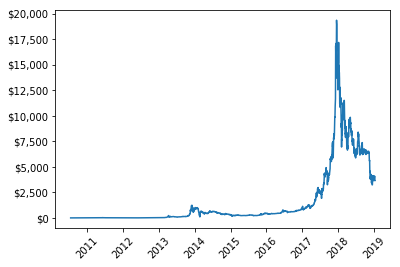

In [21]:
fig, ax = plt.subplots()
ax.plot(cdf.timestamp, cdf.close)

fmt = '${x:,.0f}'
tick = ticker.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 

plt.xticks(rotation=45)
plt.show()

---

# 2. Regelbasierte Sentiment Analysis

Da wir nun alle Daten für die anstehenden Analysen zur Verfügung haben können wir uns dem nächsten Schritt widmen. In diesem Abschnitt wollen wir die Tweets als **positiv, negativ oder neutral** klassifizieren. Dazu werden wir zwei Ansätze verfolgen, welche beide Regelbasiert sind.

* **Regelbasierter Ansatz** <br>
Regelbasierte Ansätze bauen auf Lexiken auf, bei welchen einem Wort ein bestimmter *Sentiment Score* zugeordnet wird. Positive Wörter haben dabei Bspw. Werte von 1 bis 5, negative Wörter von -1 bis -5. Innerhalb eines Dokumentes (in unserem Fall ein Tweet) werden die Werte aller Wörter summiert. Beispiele dafür sind [AFINN](https://github.com/fnielsen/afinn), [Pattern](https://www.clips.uantwerpen.be/pages/pattern-en) oder [TextBlob](https://textblob.readthedocs.io/en/dev/quickstart.html).<br>
<br><br>

## 2.1 Vader
**[Vader](https://github.com/cjhutto/vaderSentiment)** ist ein regelbasierter Klassifizierer, welche speziell für Social-Media Texte entwickelt wurde *([Paper](http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf))*. Da das Lexikon entsprechend angepasst wurde, sollte auf ein preprocessing verzichtet werden.

In [14]:
from sentiment_analysis.rule_based.vader import vader_sentiment
df = vader_sentiment(df)

## 2.2 AFINN
## TODO: Lemmatizing (siehe IR Semesterarbeit) oder nicht ?
## TODO: Modell bilden
[AFINN](https://github.com/fnielsen/afinn) ist ebenfalls ein regelbasierter Klassifizierer *([Paper](http://www2.imm.dtu.dk/pubdb/views/edoc_download.php/6006/pdf/imm6006.pdf))*. 

In [15]:
from sentiment_analysis.rule_based.afinn import afinn_sentiment
df = afinn_sentiment(df)

In [18]:
df[['full_text', 'vader_sentiment', 'afinn_sentiment', 'vader_sentiment_class', 'afinn_sentiment_class']].head(2)

full_text  \
0                                                                                                                                                                                                                                                                            @cvrbonbased Reddcoin   
1  @reddcoin #reddcoin #reddid If you post content on social media, why not get Reddcoin and ReddID? Why wouldn't you take a few steps to continue doing exactly what you are already doing but now have a chance to get tips and a chance to Stake free money? Why wouldn't you? Are you "REDDy?"   

   vader_sentiment  afinn_sentiment  vader_sentiment_class  \
0           0.0000              0.0                    0.0   
1           0.8862              5.0                    1.0   

   afinn_sentiment_class  
0                    0.0  
1                    1.0

### Vergleich von Vader und AFINN

In [19]:
delta = df.loc[df['vader_sentiment_class'] != df['afinn_sentiment_class']]
delta[['full_text', 'vader_sentiment', 'afinn_sentiment', 'vader_sentiment_class', 'afinn_sentiment_class']].head(2)

full_text  \
8                                                     @CoinWatcherBot @reddcoin Don't miss: COSSHQ_Bot - API will be officially out for public launch on the 29th October 2018, 3PM GMT +8, Singapore time. SIgn up and get 50% fee split... https://t.co/qxcOHZ4eL2 https://t.co/k9T0ykol8q   
13  ReddCoin (RDD) rocket!  0,074122 USD (803,06%) this year? The coin of the internet! Share this tweet on your #Facebook ,#instagram #Pinterest and dont forget: Retweet this! Together we can!! @reddcoinnews @reddcoin @ReddcoinBeNeLux #cryptocurrency #bitcoin https://t.co/Hk6WK6LfWX   

    vader_sentiment  afinn_sentiment  vader_sentiment_class  \
8            0.1139             -2.0                    1.0   
13           0.6167              0.0                    1.0   

    afinn_sentiment_class  
8                    -1.0  
13                    0.0

---

# 3. Machine Learning Sentiment Analysis
* ML basierter Ansatz: **Künstliche Neuronale Netze**<br>
Bisherige Studien haben im Zusammenhang mit Bitcoin bessere Resultate für Machine-Learning basierte Ansätze aufgewiesen. Wir werden ein künstliches, Neurales Netz aufbauen und trainieren. Dieses Modell sollte schliesslich ebenfalls in der Lage sein Tweets zu klassifizieren. Dabei lernt das Neurale Netz Kontext-Sensitiv, was bei dem Regelbasierten Ansätzen nur Teilweise gewährleistet ist.

Dazu wird mit einem Datensatz von 1.6 Millionen Tweets gearbeitet, welche bereits gelabelt sind. Der Datensatz stammt von [Sentiment140](http://help.sentiment140.com/for-students).

In [120]:
DATASET_ENCODING = "ISO-8859-1"
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
labeled_tweets = pd.read_csv('./data/word2vec/20000_labeled_tweets.csv', encoding=DATASET_ENCODING , names=DATASET_COLUMNS)
labeled_tweets[122:124]

target         ids                          date      flag        user  \
122       4  2191341716  Tue Jun 16 05:04:19 PDT 2009  NO_QUERY  mybrittany   
123       4  2191341725  Tue Jun 16 05:04:19 PDT 2009  NO_QUERY     misswiz   

                                                                                      text  
122                                              @LeParadis Salut Roslyn! Comment vas-tu?   
123  @KimShepherd_ Congratulations on the driving thing. Now you can have many adventures

### 3.1 Datenvorbereitung
In diesem Kapitel wird beschrieben, wie der Datensatz und die darin enthaltenen Daten für das weitere Machine Learning vorgehen vorbereitet werden.

### 3.1.1 Preprocessing
Der erste Schritt besteht darin, die Tweet-Texte von Stopwörtern, Sonderzeichen, Links und User-Verlinkungen zu bereinigen.

In [121]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

In [122]:
nltk.download('stopwords')
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

[nltk_data] Downloading package stopwords to /Users/andy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [123]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [124]:
labeled_tweets.text = labeled_tweets.text.apply(lambda x: preprocess(x))

In [125]:
labeled_tweets[122:124]

target         ids                          date      flag        user  \
122       4  2191341716  Tue Jun 16 05:04:19 PDT 2009  NO_QUERY  mybrittany   
123       4  2191341725  Tue Jun 16 05:04:19 PDT 2009  NO_QUERY     misswiz   

                                              text  
122                    salut roslyn comment vas tu  
123  congratulations driving thing many adventures

### 3.1.2 Labeling
In diesem Abschnitt wird das korrekte Labeling des Datensatzes vorgenommen.

In [126]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]
labeled_tweets.target = labeled_tweets.target.apply(lambda x: decode_sentiment(x))

In [157]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(labeled_tweets.target.tolist())

labeled_tweets.target = encoder.transform(labeled_tweets.target.tolist())

In [158]:
labeled_tweets[122:124]

target         ids                          date      flag        user  \
122       1  2191341716  Tue Jun 16 05:04:19 PDT 2009  NO_QUERY  mybrittany   
123       1  2191341725  Tue Jun 16 05:04:19 PDT 2009  NO_QUERY     misswiz   

                                              text  
122                    salut roslyn comment vas tu  
123  congratulations driving thing many adventures

Text(0.5,1,'Dataset labels distribuition')

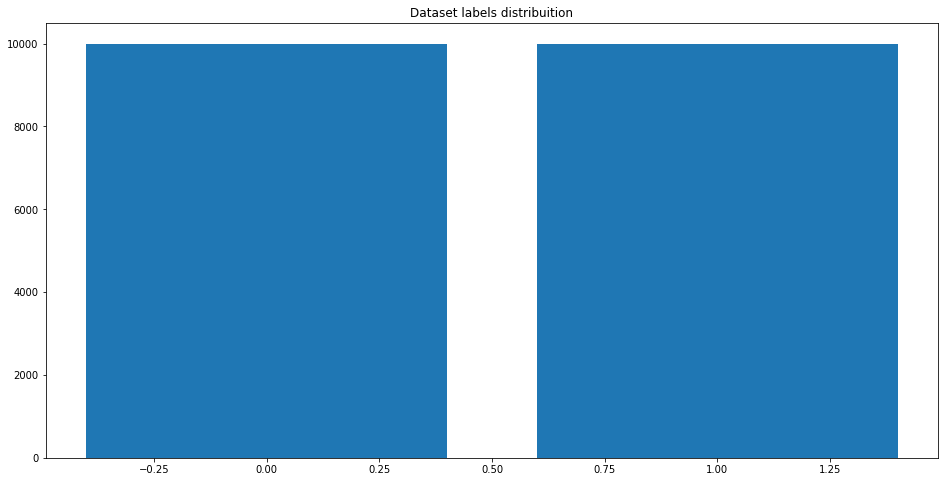

In [159]:
from collections import Counter
%matplotlib inline
target_cnt = Counter(labeled_tweets.target)
plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [160]:
labeled_tweets[122:124]

target         ids                          date      flag        user  \
122       1  2191341716  Tue Jun 16 05:04:19 PDT 2009  NO_QUERY  mybrittany   
123       1  2191341725  Tue Jun 16 05:04:19 PDT 2009  NO_QUERY     misswiz   

                                              text  
122                    salut roslyn comment vas tu  
123  congratulations driving thing many adventures

### 3.1.3 Aufteilung in Trainings- und Testdaten
Da die Daten nun bereinigt sind teilen wir diese in Test und Trainingsdaten auf. Die folgenden Modelle werden mit den Trainingsdaten erstellt. Durch diese Unterteilung können die neuen, unbekannten Daten mit den Test Datensatz simuliert und ausgewertet werden.

In [161]:
from sklearn.model_selection import train_test_split
TRAIN_SIZE = 0.8
tweets_train, tweets_test = train_test_split(labeled_tweets, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(tweets_train))
print("TEST size:", len(tweets_test))

TRAIN size: 16000
TEST size: 4000


## 3.2 Word Embeddings Modell

In diesem Abschnitt wird die Instanzierung und das Trainieren eines **Word2Vec** Modelles erläutert. Dieses wird dazu benötigt, um ein Wort in einen Nummerischen Feature-Vektor zu wandeln, bzw. ein gesammten Tweet in ein Array von solchen Wort-Feature-Vektoren umzuformen.

### 3.2.1 Word2Vec Modell

In [162]:
W2V_SIZE = 300 # Anazahl Dimensionen eines Wort-Vektors
W2V_WINDOW = 7 # Wort-Fenster welches beachtet werden soll
W2V_EPOCH = 32 # Anzahl durchläufe
W2V_MIN_COUNT = 10 # Wörter welche weniger oft vorkommen werden ignoriert

In [163]:
documents = [_text.split() for _text in tweets_train.text]
print("122: " + str(documents[122]))
print("123: " + str(documents[123]))

122: ['happy', 'chappy']
123: ['called', 'shorty']


**Word2Vec Vokabular aufbauen**<br>
Dabei werden die Dokumente Indexiert. Für jedes Wort wird eine eindeutige Nummer generiert, zudem werden vorkommnise gezählt,

In [164]:
import gensim
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, window=W2V_WINDOW, min_count=W2V_MIN_COUNT, sg=1, workers=8)
w2v_model.build_vocab(documents)

In [165]:
str(w2v_model.wv.vocab['back'])

'Vocab(count:577, index:13, sample_int:2263338924)'

**Word2Vec Modell trainieren**

In [166]:
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

(2367897, 3683904)

In [167]:
w2v_model.similar_by_word('back')

/Users/andy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.
/Users/andy/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('home', 0.7423287630081177),
 ('dad', 0.5842833518981934),
 ('lie', 0.5645618438720703),
 ('headed', 0.558099091053009),
 ('soon', 0.5481002330780029),
 ('mommy', 0.5425254106521606),
 ('arrived', 0.5322456955909729),
 ('airport', 0.5279967784881592),
 ('papers', 0.5257595777511597),
 ('heading', 0.5103989839553833)]

In [168]:
w2v_model["back"]

/Users/andy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([ 0.27323204, -0.19533558,  0.3759021 ,  0.5567499 ,  0.03495404,
       -0.0633769 ,  0.15428893,  0.19633329,  0.0299192 ,  0.40132222,
        0.12058586, -0.006266  , -0.43103123,  0.17118053,  0.2997129 ,
        0.02015254, -0.2354734 ,  0.12189814, -0.03987611, -0.01867675,
        0.00155118, -0.46714363, -0.17316867, -0.14980485, -0.05248985,
       -0.01505346,  0.1429011 , -0.43982667, -0.01601089,  0.50742316,
        0.18722603, -0.27371475, -0.44085354, -0.27155885,  0.2908164 ,
       -0.43390304,  0.16141184,  0.30819035,  0.16193874, -0.34352687,
       -0.15159245,  0.23015828,  0.24486624, -0.05053373, -0.23787402,
        0.03536155, -0.14388481,  0.26923263, -0.01080886,  0.41693482,
        0.2003831 ,  0.24416615,  0.30939063,  0.14253001, -0.30625224,
       -0.35640892, -0.08987116, -0.37227312, -0.10525412,  0.06792924,
        0.1039734 ,  0.5132448 ,  0.11829928,  0.10311839, -0.14506379,
        0.19074374, -0.05265019, -0.13813448, -0.04220093, -0.62

In [169]:
# https://medium.com/@aneesha/using-tsne-to-plot-a-subset-of-similar-words-from-word2vec-bb8eeaea6229
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
def display_closestwords_tsnescatterplot(model, word):
    arr = np.empty((0,300), dtype='f')
    word_labels = [word]

    # get close words
    close_words = model.similar_by_word(word)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

/Users/andy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  if __name__ == '__main__':
/Users/andy/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/Users/andy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
/Users/andy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


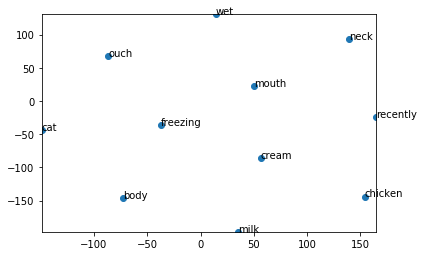

In [170]:
display_closestwords_tsnescatterplot(w2v_model, 'cat')

## 3.3 RNN Modell
In diesem Abschnitt wird die Instanzierung und das Trainieren eines RNN Modelles erläutert. Mit diesem Modell ist es schlussendlich möglich, einen Feature Vektor, welcher aus dem Word Embeddings Modell kommt in **positiv** oder **negativ** zu klassifizieren.

### 3.3.1 Embeddings Layer
[Keras](https://keras.io) bietet einen eigenen Layer für Embeddings an, den [Embedding Layer](https://keras.io/layers/embeddings/). Die Anwendung dieses Layer im Zusammenhang mit Text-Analyse [hier](https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html) demonstriert. Dabei setzt Keras auf einen eigenen [Tokenizer](https://keras.io/preprocessing/text/), welcher sich einen "eigenen" Wort-Index hält.

In [171]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM

**Wort Index aufbauen**<br>
Als erstes wird ein Wort-Index aufgebaut. Dabei wird für jedes Wort einen nummerischen Wert als Index definiert.

In [172]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tweets_train.text)

In [173]:
tokenizer.word_index['back']

14

**Index auf Tweets anwenden**<br>
Nun wird der Index auf die Tweets angewendet. Dies bedeutet, dass jedes Wort durch den Index ausgetauscht wird. Dabei wird noch ein "padding" angwendet, d.h. dass alle Tweets dabei die gleiche dimension bekommen. Die "leeren" Worte werden in diesem Fall mit 0 aufgefüllt.

In [174]:
SEQUENCE_LENGTH = 150 # 150 Wörter pro Tweet
feature_vectors = pad_sequences(tokenizer.texts_to_sequences(tweets_train.text), maxlen=SEQUENCE_LENGTH)

In [175]:
feature_vectors[122:124]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 

**Embedding Layer definieren**<br>
Der Embedding Layer nimmt jeweils einen Tweet in Form von des Tokens-Index-Vektors entgegen. Dabei werden die eigentlichen Word-Embeddings als Gewichte definiert. Diese Gewichte werden jedoch vom Trainier-Vorgang ausgeschlossen.

In [176]:
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(18421, 300)


In [177]:
embedding_matrix[tokenizer.word_index['back']]

array([ 0.27323204, -0.19533558,  0.37590209,  0.55674988,  0.03495404,
       -0.0633769 ,  0.15428893,  0.19633329,  0.0299192 ,  0.40132222,
        0.12058586, -0.006266  , -0.43103123,  0.17118053,  0.2997129 ,
        0.02015254, -0.23547339,  0.12189814, -0.03987611, -0.01867675,
        0.00155118, -0.46714363, -0.17316867, -0.14980485, -0.05248985,
       -0.01505346,  0.14290109, -0.43982667, -0.01601089,  0.50742316,
        0.18722603, -0.27371475, -0.44085354, -0.27155885,  0.2908164 ,
       -0.43390304,  0.16141184,  0.30819035,  0.16193874, -0.34352687,
       -0.15159245,  0.23015828,  0.24486624, -0.05053373, -0.23787402,
        0.03536155, -0.14388481,  0.26923263, -0.01080886,  0.41693482,
        0.2003831 ,  0.24416615,  0.30939063,  0.14253001, -0.30625224,
       -0.35640892, -0.08987116, -0.37227312, -0.10525412,  0.06792924,
        0.1039734 ,  0.51324481,  0.11829928,  0.10311839, -0.14506379,
        0.19074374, -0.05265019, -0.13813448, -0.04220093, -0.62

In [178]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

### 3.3.2 Neuronales Netz
* **Embedding Layer**<br>
Den Embedding-Layer kann man sich wie ein Dictionary vorstellen, das den ganzzahligen
Indizes (die für bestimmte Wörter stehen) dichtbesetzte Vektoren zuordnet.
Er nimmt Integer als Eingabe entgegen, durchsucht ein internes Dictionary
und gibt den dazugehörigen Vektor zurück. Faktisch handelt es sich hier um ein
Nachschlagen im Dictionary (Chollet, S. 240).
* **Dropout Layer**<br>
Der Droupout Layer implementiert das Dropout Regularisierungsverfahren. Während des Trainings werden züfällig einige Ausgabemerkmale des Layers gelöscht, bzw. auf null gesetzt. Die Dropoutquote (rate, parameter) gibt den Anteil der Merkmale an, die durch 0 ersetzt werden (liegt meist zwischen 0.2 und 0.5) (Chollet, S. 149).
* **LSTM Layer**<br>
Er fügt eine Möglichkeit hinzu, Informationen über viele Zeitschritte
hinweg zu erhalten. Stellen Sie sich ein Förderband vor, das parallel zu der
verarbeitenden Sequenz verläuft. Die in der Sequenz enthaltenen Informationen
können bei Bedarf zu jedem beliebigen Zeitpunkt auf das Förderband wechseln,
sich zu einem späteren Zeitschritt befördern lassen und dort wieder unbeschadet
zurückwechseln. Das ist im Wesentlichen das, was der LSTM-Layer leistet: Informationen
für den späteren Gebrauch speichern und so verhindern, dass ältere Signale
während der Verarbeitung allmählich verschwinden (Chollet, S. 260).
* **Dense Layer**<br>
Dieser Layer kann als eine Funktion verstanden werden, die einen 2-D-Tensor als
Eingabe entgegennimmt und einen weiteren 2-D-Tensor zurückliefert – eine neue
Repräsentation des Eingabetensors (Chollet, S. 62).<br>
Der letzte Layer nutzt zur Aktivierung eine Sigmoidfunktion, um eine Wahrscheinlichkeit
ausgeben zu können (einen Wert zwischen 0 und 1, der angibt, wie wahrscheinlich
es ist, dass das fragliche Sample den Zielwert 1 besitzt, also wie hoch
die Wahrscheinlichkeit ist, dass die Bewertung positiv ist) (Chollet, S. 100).

In [179]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 300, 300)          5526300   
_________________________________________________________________
dropout_2 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 5,686,801
Trainable params: 160,501
Non-trainable params: 5,526,300
_________________________________________________________________


**Modell kompilieren**

In [182]:
model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])

### 3.3.3 Modell trainieren
In diesem Abschnitt wird erklärt, wie das RNN Modell trainiert wird.

In [188]:
x_train = pad_sequences(tokenizer.texts_to_sequences(tweets_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(tweets_test.text), maxlen=SEQUENCE_LENGTH)
y_train = tweets_train.target
y_test = tweets_test.target
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (16000, 300)
y_train (16000, 1)

x_test (4000, 300)
y_test (4000, 1)


/Users/andy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """
/Users/andy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


In [184]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [186]:
%%time
EPOCHS = 8
BATCH_SIZE = 1024
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Train on 14400 samples, validate on 1600 samples
Epoch 1/8
14400/14400 [==============================] - 127s 9ms/step - loss: 0.6093 - acc: 0.6676 - val_loss: 0.6099 - val_acc: 0.6663
Epoch 2/8
14400/14400 [==============================] - 125s 9ms/step - loss: 0.5944 - acc: 0.6783 - val_loss: 0.5960 - val_acc: 0.6619
Epoch 3/8
14400/14400 [==============================] - 128s 9ms/step - loss: 0.5885 - acc: 0.6817 - val_loss: 0.5912 - val_acc: 0.6794
Epoch 4/8
14400/14400 [==============================] - 124s 9ms/step - loss: 0.5823 - acc: 0.6903 - val_loss: 0.5891 - val_acc: 0.6750
Epoch 5/8
14400/14400 [==============================] - 124s 9ms/step - loss: 0.5777 - acc: 0.6933 - val_loss: 0.5849 - val_acc: 0.6769
Epoch 6/8
14400/14400 [==============================] - 125s 9ms/step - loss: 0.5759 - acc: 0.6919 - val_loss: 0.5820 - val_acc: 0.6844
Epoch 7/8
14400/14400 [==============================] - 128s 9ms/step - loss: 0.5697 - acc: 0.6994 - val_loss: 0.5786 - val_acc:

### 3.3.4 Modell auf Testdaten anwenden

In [189]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

4000/4000 [==============================] - 22s 5ms/step

ACCURACY: 0.7079999952316284
LOSS: 0.5657377362251281
CPU times: user 41.2 s, sys: 5.07 s, total: 46.3 s
Wall time: 21.8 s


### 3.3.5 Modell auswerten

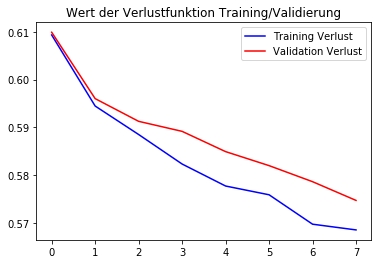

In [194]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training Genauigkeit')
plt.plot(epochs, val_acc, 'r', label='Validation Genauigkeit')
plt.title('Wert der Genauigkeit')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training Verlust')
plt.plot(epochs, val_loss, 'r', label='Validation Verlust')
plt.title('Wert der Verlustfunktion Training/Validierung')
plt.legend()
 
plt.show()

## 3.4 Modelle abspeichern

In [192]:
import pickle
KERAS_MODEL = "sa_classifier_model.h5"
WORD2VEC_MODEL = "word_embeddings_model.w2v"
TOKENIZER_MODEL = "tokenizer_model.pkl"
ENCODER_MODEL = "encoder_model.pkl"

model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

---

# 4. Sentiment Klassifizierung der Tweets